<a href="https://colab.research.google.com/github/RonBartov/Introduction_to_Optimization/blob/main/ls_rls_image_deblurring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Least Square and Regularized Least Squares for Reconstructing Image Pixels**


In [28]:
import numpy as np
import scipy as sp
from scipy import sparse
import cv2 as cv
import matplotlib.pyplot as plt
from google.colab import drive

# **Introduction**
Consider the model $Y = AX + W$, where $Y$ is the observed data, $A$ is the known blurring matrix, $X$ is the original image, and $W$ is white Gaussian noise ($W \sim \mathcal{N}(0, \sigma^2 I)$).

<br>

## **Least Squares (LS) Method**
The LS method aims to find the estimate $\hat{X}_{\text{LS}}$ that minimizes the sum of squared errors between the observed data $Y$ and the model $AX$:

$\hat{X}_{\text{LS}} = \underset{X}{\arg\min} \| Y - AX \|_2^2\$

This can be solved using the normal equation:

$\hat{X}_{\text{LS}} = (A^T A)^{-1} A^T Y$


- $A$ is the known blurring matrix.
- $Y$ is the observed (blurred and noisy) image.
- $W$ is white Gaussian noise, meaning $W \sim \mathcal{N}(0, \sigma^2 I)$.
<br>

### Proof
Given the objective function:

$J(X) = \| Y - AX \|_2^2 = (Y - AX)^T (Y - AX)$

To find the minimum, we take the derivative with respect to $X$ and set it to zero:

$\frac{\partial J(X)}{\partial X} = -2A^T (Y - AX) = 0$

Solving for $X$:

$A^T Y - A^T AX = 0 \implies A^T AX = A^T Y \implies \hat{X}_{\text{LS}} = (A^T A)^{-1} A^T Y$

<br>

## **Regularized Least Squares (RLS) Method**
The RLS method introduces a regularization term to the LS objective function to penalize large values of $X$, which can help mitigate the effects of noise and ill-conditioning in $A$:

$\hat{X}_{\text{RLS}} = \underset{X}{\arg\min} \left( \| Y - AX \|_2^2 + \lambda \| X \|_2^2 \right)$

This can be solved using the modified normal equation:

$\hat{X}_{\text{RLS}} = (A^T A + \lambda I)^{-1} A^T Y$

- $\lambda$ is the regularization parameter.
- The term $\lambda \| X \|_2^2$ penalizes large values in $X$, making the solution more robust to noise.

The regularization term helps to stabilize the solution, especially when $A$ is ill-conditioned or singular. It prevents overfitting to the noise in the observed data $Y$.
<br>

### Proof
Given the objective function with regularization:

$J(X) = \| Y - AX \|_2^2 + \lambda \| X \|_2^2
$

Expanding and simplifying:

$J(X) = (Y - AX)^T (Y - AX) + \lambda X^T X$

<br>

To find the minimum, we take the derivative with respect to $X$ and set it to zero:

$\frac{\partial J(X)}{\partial X} = -2A^T (Y - AX) + 2\lambda X = 0$

Solving for $X$:

$-2A^T Y + 2A^T AX + 2\lambda X = 0 \implies A^T AX + \lambda X = A^T Y \implies (A^T A + \lambda I)X = A^T Y$

Therefore, the RLS solution is:

$\hat{X}_{\text{RLS}} = (A^T A + \lambda I)^{-1} A^T Y$

<br>

## **Summary**
**LS Method:** Minimizes the squared error between  Y  and  AX , providing the best fit in the least squares sense.

**RLS Method:** Adds a regularization term to the LS objective function to penalize large values of  X , which helps in dealing with noise and ill-conditioned  A.

Both methods are useful in image reconstruction, with RLS providing more robust solutions in the presence of noise and ill-conditioning.

# **Simulation Description**
We will perform image blurring on a given image

Then, by using LS and RLS methods as described in the 'Introduction' section, we will try to restore the original image.

In [35]:
def blurring(img):
    '''
    Input: img - An image in grayscale
    Output: X - the image after normalization. to be used as the "original image"
    Y - blured image
    A - bluring matrix (csc_matrix)
    '''

    # Standard deviation for the added noise
    sig = 1e-1

    # Normalize the image:
    # Subtract the minimum value to shift the data to start at 0
    X = img-np.min(img)

    # Divide by the maximum value to scale the data to range [0, 1]
    X = np.divide(X, np.amax(X))

    # Get the dimensions of the normalized image
    (n1, n2) = X.shape

    # Define the number of diagonals to include in the sparse matrix
    ker = 10

    # Create an array of offsets for the diagonals
    offset = np.arange(100)

    # Shuffle the offsets to randomize the placement of the diagonals
    np.random.shuffle(offset)

    # Create a sparse diagonal matrix with 'ker' diagonals
    # Each diagonal will have ones, and they will be placed at the positions defined by 'offset[:ker] - 25'
    # This essentially shifts the diagonals to different positions
    A = sparse.spdiags(np.ones((ker, n1)), offset[:ker]-25, n1, n1)

    # Generate white Gaussian noise with mean 0 and standard deviation 1, matching the image dimensions
    W = np.random.normal(0, 1, (n1, n2))

    # Convert the sparse matrix to a dense array for matrix multiplication
    A = A.toarray()

    # Apply the blurring effect by multiplying the blurring matrix A with the normalized image X
    # Add noise scaled by the standard deviation 'sig'
    Y = A.dot(X) + sig * W
    return A, Y, X

In [37]:
# Mount to google drive for loading an image
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
# Load a grayscale image from drive
image_path = r'/content/drive/MyDrive/Colab Notebooks/testimg.jpg'
image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

In [47]:
# Reshape the image for convenience
img_dim = 200
image = cv.resize(image, (img_dim, img_dim))

In [48]:
# Apply the blurring function
A, Y, X = blurring(image)
print(f"X shape: {X.shape} ; Y shape: {Y.shape} ; A shape: {A.shape}")

X shape: (200, 200) ; Y shape: (200, 200) ; A shape: (200, 200)


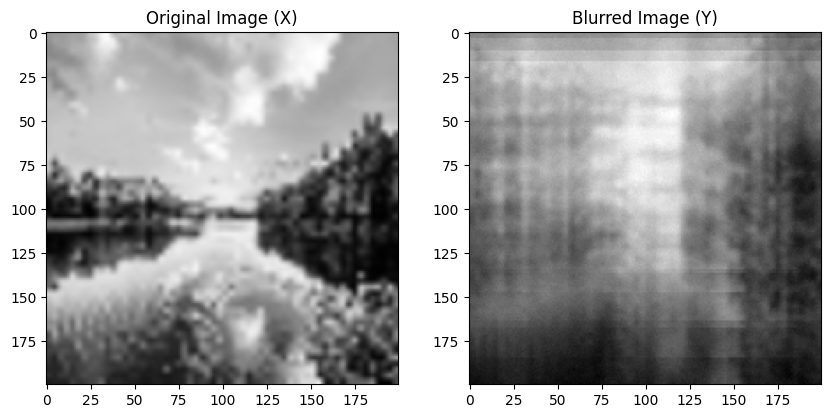

In [49]:
# Plotting original and blurred images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image (X)')
plt.imshow(X, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Blurred Image (Y)')
plt.imshow(Y, cmap='gray')
plt.show()

In [50]:
# Perform the LS method
X_LS = np.linalg.inv(A.T @ A) @ A.T @ Y

In [51]:
# Perform the RLS method
lambda_par = 0.6
I = np.eye(A.shape[1])
X_RLS = np.linalg.inv(A.T @ A + lambda_par * I) @ A.T @ Y

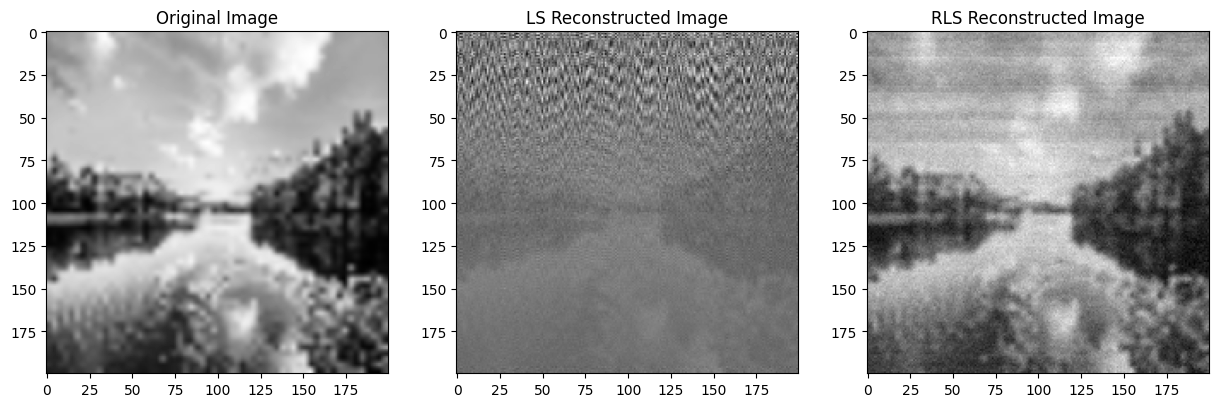

In [52]:
# Plot the results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(X, cmap='gray')
plt.subplot(1, 3, 2)
plt.title('LS Reconstructed Image')
plt.imshow(X_LS, cmap='gray')
plt.subplot(1, 3, 3)
plt.title('RLS Reconstructed Image')
plt.imshow(X_RLS, cmap='gray')
plt.show()